In [1]:

# Turn off Pretty Print, enable inline plotting with Matplotlib, add py folder to system path, import jobpostlib modules
%pprint
%matplotlib inline
import sys
import os.path as osp
sys.path.insert(1, osp.abspath('../py'))
from notebook_utils import NotebookUtilities
from pandas import DataFrame
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from tqdm import tqdm

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)

Pretty printing has been turned OFF



# Distribution of Average Resources by Ethnocentrism Group

In [2]:

# Define the Group class
class Group:
    def __init__(self, name, pos_ethno, neg_ethno):
        self.name = name
        self.pos_ethno = pos_ethno  # Positive ethnocentrism (in-group favoritism)
        self.neg_ethno = neg_ethno  # Negative ethnocentrism (out-group hostility)
        self.members = []

    # Add a member to the group
    def add_member(self, member):
        self.members.append(member)

    # Check if the group has no members
    def is_empty(self):
        return len(self.members) == 0

In [3]:

# Define the Individual class
class Individual:
    def __init__(self, group):
        self.group = group
        self.resources = 100  # Starting resources

In [4]:

# Initialize the population with given group configurations and population size
def initialize_population(group_configs, population_size):
    groups = [Group(name, pos, neg) for name, pos, neg in group_configs]
    population = []
    for _ in range(population_size):
        group = random.choice(groups)
        individual = Individual(group)
        group.add_member(individual)
        population.append(individual)
    return population, groups

In [5]:

# Define the interaction between two individuals
def interact(interacting_individual, target_individual):
    same_group = interacting_individual.group == target_individual.group
    
    if same_group:
        cooperation_chance = interacting_individual.group.pos_ethno
    else:
        cooperation_chance = 1 - interacting_individual.group.neg_ethno
    
    # Cooperation: both gain resources
    if random.random() < cooperation_chance:
        interacting_individual.resources += 10
        target_individual.resources += 10
    
    # Conflict: one gains, one loses
    else:
        if random.random() < 0.5:
            interacting_individual.resources += 20
            target_individual.resources -= 10
        else:
            interacting_individual.resources -= 10
            target_individual.resources += 20

In [6]:

# Run the simulation for a given number of interactions
def run_simulation(population, num_interactions):
    for _ in range(num_interactions):
        ind1, ind2 = random.sample(population, 2)
        interact(ind1, ind2)

In [7]:

# Analyze the results of the simulation
def analyze_results(groups, verbose=True):
    rows_list = []
    for group in groups:
        if group.is_empty():
            avg_resources = np.nan
            if verbose: print(f"{group.name}: No members")
        else:
            avg_resources = sum(m.resources for m in group.members) / len(group.members)
            if verbose: print(f"{group.name}: Average resources = {avg_resources:.2f}")
        row_dict = {'group_name': group.name, 'average_resources': avg_resources, 'pos_ethno': group.pos_ethno, 'neg_ethno': group.neg_ethno}
        rows_list.append(row_dict)
    
    return DataFrame(rows_list)

In [8]:

# Set up and run simulation
group_configs = []
for pos_ethno in range(0, 11, 1):
    for neg_ethno in range(0, 11, 1):
        group_tuple = (f'Group {pos_ethno:02}{neg_ethno:02}', pos_ethno/10, neg_ethno/10)
        group_configs.append(group_tuple)

# Initialize the population and groups
population, groups = initialize_population(group_configs, population_size=3000)

# Run the simulation with the specified number of interactions
run_simulation(population, num_interactions=10000)

# Analyze the results and store them in a DataFrame
df = analyze_results(groups, verbose=False)

In [9]:

# Calculate correlations
correlations = df[['average_resources', 'pos_ethno', 'neg_ethno']].corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlations)

Correlation matrix:
                   average_resources     pos_ethno     neg_ethno
average_resources           1.000000  1.065526e-01 -5.536227e-01
pos_ethno                   0.106553  1.000000e+00  1.880956e-16
neg_ethno                  -0.553623  1.880956e-16  1.000000e+00


In [10]:

# Extract specific correlations
corr_pos_ethno = correlations.loc['average_resources', 'pos_ethno']
corr_neg_ethno = correlations.loc['average_resources', 'neg_ethno']

print(f"Correlation between average_resources and pos_ethno: {corr_pos_ethno:.4f}")
print(f"Correlation between average_resources and neg_ethno: {corr_neg_ethno:.4f}")

Correlation between average_resources and pos_ethno: 0.1066
Correlation between average_resources and neg_ethno: -0.5536


In [11]:

# Calculate Spearman rank correlation
spearman_corr = df[['average_resources', 'pos_ethno', 'neg_ethno']].corr(method='spearman')

print("Spearman rank correlation:")
print(spearman_corr)

Spearman rank correlation:
                   average_resources  pos_ethno  neg_ethno
average_resources           1.000000   0.108683  -0.569716
pos_ethno                   0.108683   1.000000   0.000000
neg_ethno                  -0.569716   0.000000   1.000000


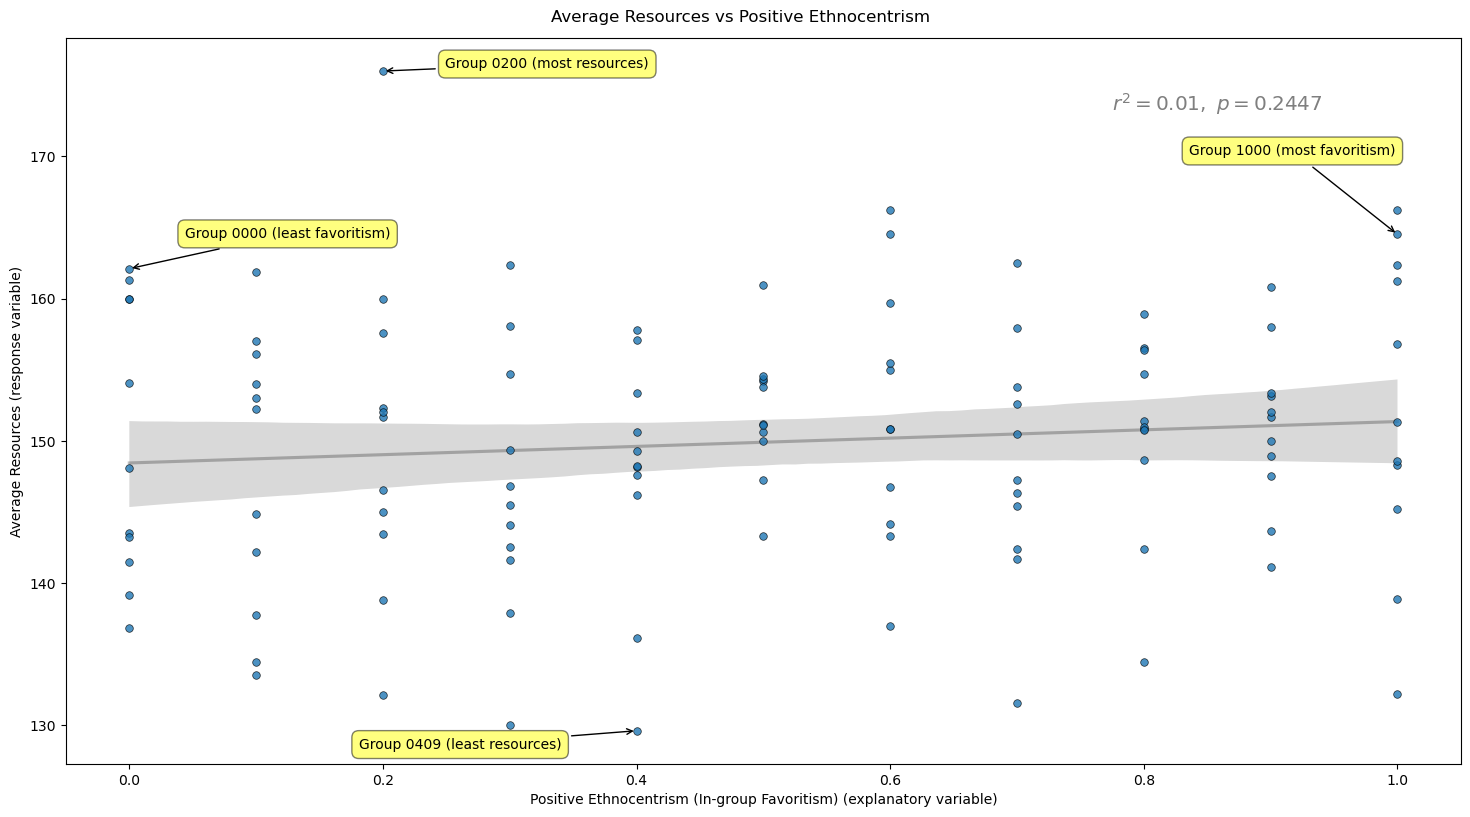

In [17]:

fig, ax = nu.first_order_linear_scatterplot(
    df.set_index('group_name'),
    'pos_ethno',
    'average_resources',
    xlabel_str='Positive Ethnocentrism (In-group Favoritism)',
    ylabel_str='Average Resources',
    x_adj='favoritism',
    y_adj='resources',
    title='Average Resources vs Positive Ethnocentrism',
    least_x_xytext=(40, 20),
    most_x_xytext=(-150, 55),
    least_y_xytext=(-200, -15),
    most_y_xytext=(45, 0),
)

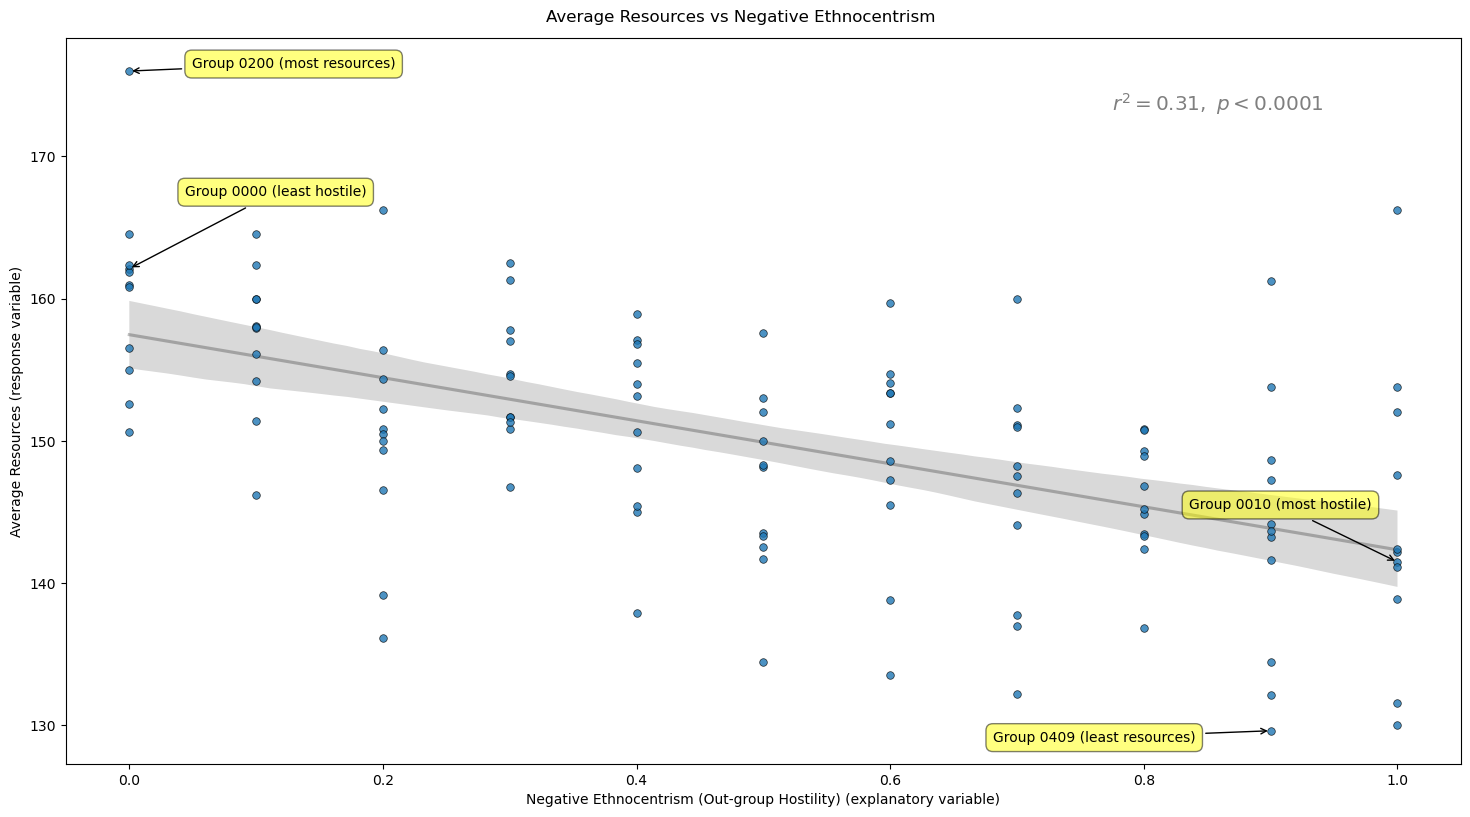

In [21]:

fig, ax = nu.first_order_linear_scatterplot(
    df.set_index('group_name'),
    'neg_ethno',
    'average_resources',
    xlabel_str='Negative Ethnocentrism (Out-group Hostility)',
    ylabel_str='Average Resources',
    x_adj='hostile',
    y_adj='resources',
    title='Average Resources vs Negative Ethnocentrism',
    least_x_xytext=(40, 50),
    most_x_xytext=(-150, 36),
    least_y_xytext=(-200, -10),
    most_y_xytext=(45, 0),
)

In [13]:

# Categorize the groups
categorize_ethno = lambda value: 'High' if value >= 0.5 else 'Low'
df['pos_ethno_cat'] = df['pos_ethno'].apply(categorize_ethno)
df['neg_ethno_cat'] = df['neg_ethno'].apply(categorize_ethno)
df['ethno_group'] = df['pos_ethno_cat'] + '/' + df['neg_ethno_cat']

# Calculate summary statistics
summary = df.groupby('ethno_group')['average_resources'].agg(['mean', 'std', 'count'])
print("Summary Statistics:")
print(summary)

Summary Statistics:
                   mean       std  count
ethno_group                             
High/High    146.164052  8.155798     36
High/Low     154.536418  7.018512     30
Low/High     147.427741  8.856792     30
Low/Low      154.010927  6.250007     25


In [14]:

# Perform one-way ANOVA
groups = [group for _, group in df.groupby('ethno_group')['average_resources']]
f_statistic, p_value = stats.f_oneway(*groups)
print(f"One-way ANOVA results:")
print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")


One-way ANOVA results:
F-statistic: 9.760389891301191
p-value: 8.487263028660921e-06



The One-way ANOVA results indicate that there is a statistically significant difference between the means of the four ethno groups. Here's the interpretation:

- **F-statistic: 9.760** - This value represents the ratio of the variance between the group means to the variance within the groups. A higher F-statistic suggests a greater difference between the group means.
- **p-value: 8.487e-06** - This value is much smaller than the common significance level (e.g., 0.05), indicating that the differences between the group means are statistically significant.

Given the summary statistics and the ANOVA results, we can conclude that the means of the ethno groups (High/High, High/Low, Low/High, Low/Low) are significantly different from each other.

In [15]:

# Conduct post-hoc tests (Tukey's HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['average_resources'], df['ethno_group'])
print("Tukey's HSD results:")
print(tukey_results)


Tukey's HSD results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1   group2  meandiff p-adj   lower    upper  reject
----------------------------------------------------------
High/High High/Low   8.3724 0.0001   3.3998  13.345   True
High/High Low/High   1.2637  0.911  -3.7089  6.2363  False
High/High  Low/Low   7.8469 0.0009   2.6101 13.0837   True
 High/Low Low/High  -7.1087 0.0029 -12.3024  -1.915   True
 High/Low  Low/Low  -0.5255 0.9944  -5.9727  4.9217  False
 Low/High  Low/Low   6.5832  0.011    1.136 12.0304   True
----------------------------------------------------------



The Tukey's HSD (Honestly Significant Difference) test results provide pairwise comparisons between the means of the different ethno groups. Here's the interpretation:

- **High/High vs. High/Low**: The mean difference is 8.3724, with a p-adj value of 0.0001. Since the p-adj value is less than 0.05, the difference is statistically significant. The confidence interval (3.3998 to 13.345) does not include zero, confirming the significance.
- **High/High vs. Low/High**: The mean difference is 1.2637, with a p-adj value of 0.911. The difference is not statistically significant as the p-adj value is greater than 0.05. The confidence interval (-3.7089 to 6.2363) includes zero.
- **High/High vs. Low/Low**: The mean difference is 7.8469, with a p-adj value of 0.0009. The difference is statistically significant. The confidence interval (2.6101 to 13.0837) does not include zero.
- **High/Low vs. Low/High**: The mean difference is -7.1087, with a p-adj value of 0.0029. The difference is statistically significant. The confidence interval (-12.3024 to -1.915) does not include zero.
- **High/Low vs. Low/Low**: The mean difference is -0.5255, with a p-adj value of 0.9944. The difference is not statistically significant. The confidence interval (-5.9727 to 4.9217) includes zero.
- **Low/High vs. Low/Low**: The mean difference is 6.5832, with a p-adj value of 0.011. The difference is statistically significant. The confidence interval (1.136 to 12.0304) does not include zero.

In summary, the significant differences are found between:
- High/High and High/Low
- High/High and Low/Low
- High/Low and Low/High
- Low/High and Low/Low

These results indicate that certain ethno groups have significantly different means from each other.

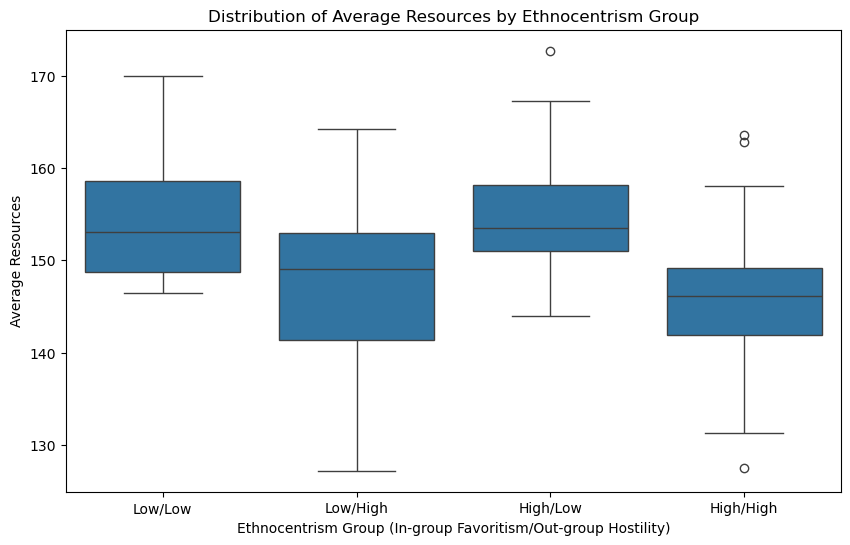

In [16]:

# Visualize the results in a whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ethno_group', y='average_resources', data=df)
plt.title('Distribution of Average Resources by Ethnocentrism Group')
plt.xlabel('Ethnocentrism Group (In-group Favoritism/Out-group Hostility)')
plt.ylabel('Average Resources')
plt.show()

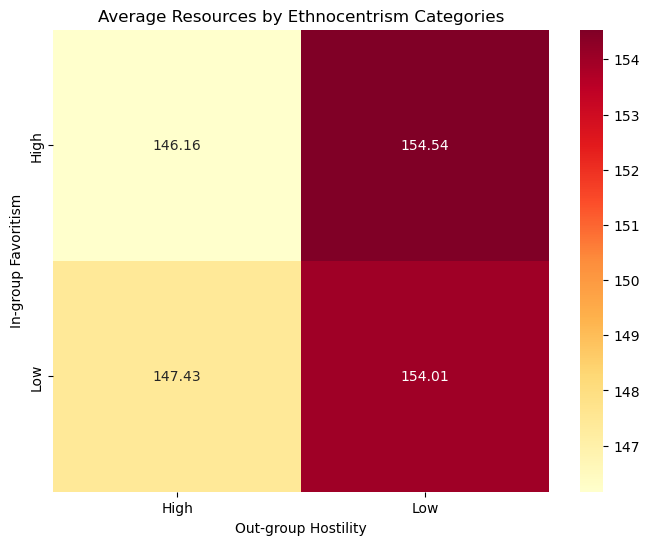

In [17]:

# Additional visualization: heatmap
pivot_df = df.pivot_table(values='average_resources', index='pos_ethno_cat', columns='neg_ethno_cat', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Average Resources by Ethnocentrism Categories')
plt.ylabel('In-group Favoritism')
plt.xlabel('Out-group Hostility')
plt.show()